In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as tf
import torch.optim as optim

from utils import flow2rgb
from utils import rgb2gray
from utils import read_flo
from utils import read_image
from torch.autograd import variable

from scipy.integrate import dblquad
from numpy.linalg import norm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [9]:
def numpy2torch(array):
    """ Converts 3D numpy HWC ndarray to 3D PyTorch CHW tensor."""
    assert (array.ndim == 3)

    result = array
    result = np.moveaxis(result,[1,2,0],[2,0,1])
    result = torch.from_numpy(result)
    
    return result


In [10]:
def torch2numpy(tensor):
    """ Convert 3D PyTorch CHW tensor to 3D numpy HWC ndarray."""
    assert (tensor.dim() == 3)

    result = tensor.permute(1,2,0).numpy()
    return result

In [11]:
def load_data(im1_filename, im2_filename, flo_filename):
    """ Loads images and flow ground truth. Returns 4D tensors."""
    i0_path = os.path.dirname(os.path.abspath("A3_P2"))+"/"+im1_filename
    i1_path = os.path.dirname(os.path.abspath("A3_P2"))+"/"+im2_filename
    flo_path = os.path.dirname(os.path.abspath("A3_P2"))+"/"+flo_filename
    i0 = read_image(i0_path)
    i0 = rgb2gray(i0)
    i1 = read_image(i1_path)
    i1 = rgb2gray(i1)    
    tensor1 = numpy2torch(i0).view(1,1,i0.shape[0],i0.shape[1])
    tensor2 = numpy2torch(i1).view(1,1,i1.shape[0],i1.shape[1])
    flow_gt = numpy2torch(read_flo(flo_path)).view(1,2,i1.shape[0],i1.shape[1])

    return tensor1, tensor2, flow_gt

In [12]:
def evaluate_flow(flow, flow_gt):
    """
    Evaluate the average endpoint error w.r.t the ground truth flow_gt.
    Excludes pixels, where u or v components of flow_gt have values > 1e9.
    """
    
    assert (flow.dim() == 4 and flow_gt.dim() == 4)
    assert (flow.size(1) == 2 and flow_gt.size(1) == 2)

    u = flow[0,0,:,:] * flow[0,0,:,:].le(1e9).float()
    v = flow[0,1,:,:] * flow[0,1,:,:].le(1e9).float()
    #u = flow[0,0,:,:]
    #v = flow[0,1,:,:]
    
    # Filter for invalid pixels
    u_gt = flow_gt[0,0,:,:] * flow_gt[0,0,:,:].le(1e9).float()
    v_gt = flow_gt[0,1,:,:] * flow_gt[0,1,:,:].le(1e9).float()

    # AEPE for each pixel
    errors = np.sqrt((u-u_gt)**2 + (v-v_gt)**2)
    
    #print(errors)
    
    # Average over all pixels
    aepe = sum(sum(errors))/errors.nelement()

    return aepe

In [13]:
def warp_image(im, flow):
    """ Warps given image according to the given optical flow."""
    assert (im.dim() == 4 and flow.dim() == 4)
    assert (im.size(1) in [1,3] and flow.size(1) == 2)
    
    # Permute dimensions and range of flow for grid_sample()
    norm_flow = torch.Tensor(flow.permute(0,2,3,1))
    # You have to add the meshgrid according to this:
    # https://discuss.pytorch.org/t/warp-video-frame-from-optical-flow/6013/4
    W=norm_flow.size(1)
    H=norm_flow.size(2)    
    
    meshH, meshW= torch.meshgrid([torch.linspace(0,W-1,W), torch.linspace(0,H-1,H)])
    meshH=torch.t(meshH).reshape(1,1,H,W)
    meshW=torch.t(meshW).reshape(1,1,H,W)
    grid = torch.cat((meshW,meshH),1).permute(0,3,2,1)
       
    norm_flow = norm_flow + grid
    
    norm_flow[:,:,:,0] = norm_flow[:,:,:,0] / (norm_flow.size(2)-1) # normalize it to (0,1)
    norm_flow[:,:,:,1] = norm_flow[:,:,:,1] / (norm_flow.size(1)-1) # normalize it to (0,1)
    
    # Clip it to range (-1,1) for the grid_sample function
    norm_flow = norm_flow*2 - 1 
    
    # Interpolate the image with the flow
    warped = tf.grid_sample(im, norm_flow)
    
    return warped

In [14]:
def visualize_warping_practice(im1, im2, flow_gt):
    """ Visualizes the result of warping the second image by ground truth."""
    print("\nWarping practice ...")
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) in [1,3] and im2.size(1) in [1,3] and flow_gt.size(1) == 2)
    
    warped_im2 = warp_image(im2, flow_gt)
    
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.title("Image 1")
    plt.imshow(im1[0,0,:,:], cmap="gray")
    plt.subplot(132)
    plt.title("Warped Image 2")
    plt.imshow(warped_im2[0,0,:,:], cmap="gray")
    plt.subplot(133)
    plt.title("Difference")
    plt.imshow(im1[0,0,:,:]-warped_im2[0,0,:,:], cmap="gray")
    plt.show()
    
    return None

In [15]:
def energy_hs(im1, im2, flow, lambda_hs):
    """ Evalutes Horn-Schunck energy function."""
    assert (im1.dim() == 4 and im2.dim() == 4 and flow.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow.size(1) == 2)

    # (Using sum instead of integral (discrete pixels in picture))
    It1 = warp_image(im2,flow)
    It0 = im1
    
    # Apply Sobel filter on u(x,y) and v(x,y) to get their gradients    
    
    #flipped sobels
    sobel_filter_x = torch.Tensor([[[[1., 0. , -1.], [2., 0., -2.], [1., 0. , -1.]]]])/4
    sobel_filter_y = torch.Tensor([[[ [1., 2., 1.], [0., 0., 0.],[-1., -2., -1.]]]])/4
    
    
    u = flow[:,0,:,:].unsqueeze(0)
    v = flow[:,1,:,:].unsqueeze(0)

    
    du_dx = tf.conv2d(u, sobel_filter_x, padding=1)    
    du_dy = tf.conv2d(u, sobel_filter_y, padding=1)                                         
    dv_dx = tf.conv2d(v, sobel_filter_x, padding=1)
    dv_dy = tf.conv2d(v, sobel_filter_y, padding=1)
    
    
                                             
    energy = torch.sum((It1-It0)**2) + torch.sum(lambda_hs*(du_dx**2+du_dy**2+(dv_dx**2+dv_dy**2)))

    return energy

In [16]:
def estimate_flow(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter):
    """
    Estimate flow using HS with Gradient Descent.
    Displays average endpoint error.
    Visualizes flow field.

    Returns estimated flow]
    """
    
    print("\nGradient Descent ...")
    
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow_gt.size(1) == 2)

    # Initial flow
    flow = torch.rand(1,2,flow_gt.size(2),flow_gt.size(3),requires_grad=True)
    
    for i in np.arange(0, num_iter):
        
        # Forward pass   
        loss = energy_hs(im1,im2,flow,lambda_hs)
        
        if not i%50: print("Iteration: {} Loss: {}".format(i+1, loss))
        
        # Backward pass
        loss.backward()
        
        # Gradient descent step
        update = flow.grad
        with torch.no_grad():
            flow -= update * learning_rate 
        flow.grad.zero_()
    
    print("Gradient Descent AEPE: ", evaluate_flow(flow.data, flow_gt))
    with torch.no_grad():
        plt.figure()
        plt.title("Flow estimated with gradient descent")
        plt.imshow(flow2rgb(torch2numpy(flow.data.resize(flow.size(1),flow.size(2),flow.size(3)))))
        plt.show()
        
    
    return flow

In [17]:
def estimate_flow_LBFGS(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter):
    """
    Estimates flow using HS with LBFGS.
    Displays average endpoint error.
    Visualizes flow field.

    Returns estimated flow
    """
    
    print("\nLBFGS ...")
    
    # Initial flow
    flo = torch.rand(1,2,im1.size(2),im1.size(3))
    flo.requires_grad = True
    
    global c
    c = 0
    
    optimizer = torch.optim.LBFGS(params=[flo], lr=learning_rate, max_iter=num_iter)

    
    def closure():
        global c
        c =  c + 1
        optimizer.zero_grad()
        #loss = energy_hs(im1,im2,flo,lambda_hs).clone().detach().requires_grad_(True)
        loss = energy_hs(im1,im2,flo,lambda_hs)
        if not c%50: print("Iteration: {} Loss: {}".format(c, loss))
        loss.backward()
        return loss
    
    optimizer.step(closure)
    
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow_gt.size(1) == 2)
    
    print("LBFGS AEPE: ", evaluate_flow(flo.data, flow_gt))
    with torch.no_grad():
        plt.figure()
        plt.title("Flow estimated with LBFGS")
        plt.imshow(flow2rgb(torch2numpy(flo.data.resize(flo.size(1),flo.size(2),flo.size(3)))))
        plt.show()
        
    return

In [90]:
def estimate_flow_coarse_to_fine(im1, im2, flow_gt, lambda_hs, learning_rate,
                                 num_iter, num_level):
    """
    Estimates flow using HS with LBFGS in a coarse-to-fine scheme.
    Displays average endpoint error.
    Visualizes flow field.

    Returns estimated flow
    """
    print("\nCoarse to fine ...")
    
    # Figure with subplots for plots
    figg, axes = plt.subplots(1, num_level, figsize=(15,15))
    
    # Initial flow
    flo = torch.rand(1,2,int(im1.size(2)/num_level),int(im1.size(3)/num_level))
    flo.requires_grad = True
    
    # Loop over levels
    for l in np.flip(np.arange(1, num_level+1)):
        
        og_size = (im1.shape[2],im1.shape[3])
        down_size = (im1.shape[2]//l,im1.shape[3]//l)
        
        print("Level {}".format(l))
        sampling = torch.nn.Upsample(down_size, mode='bilinear', align_corners=False)
        downsampled_im1 = sampling(im1)
        downsampled_im2 = sampling(im2)
        downsampled_flow_gt = sampling(flow_gt)
        flo=torch.tensor(sampling(flo).data, requires_grad=True)
        
        global c
        c = 0
        
        optimizer = torch.optim.LBFGS(params=[flo], lr=learning_rate, max_iter=num_iter)
        
        def closure():
            global c
            c =  c + 1
            optimizer.zero_grad()
            loss = energy_hs(downsampled_im1, downsampled_im2,flo,lambda_hs)
            # if not c%50: print("Iteration: {} Loss: {}".format(c, loss))
            loss.backward()
            return loss
        
        # Optimize flow for current level 
        optimizer.step(closure)
        
        #print("LBFGS AEPE: ", evaluate_flow(flo.data, downsampled_flow_gt))
        with torch.no_grad():
            # Upsample current image (flow) from pyramid to full resolution
            plot_scale_factor = num_level/l
            sample = torch.nn.Upsample(og_size, mode='bilinear', align_corners=False)
            full_res_flo = sample(flo)
            print("LBFGS AEPE: ", evaluate_flow(full_res_flo.data, flow_gt))
            # Plot
            axes[l-1].imshow(flow2rgb(torch2numpy(full_res_flo.data.resize(full_res_flo.size(1),
                                                                           full_res_flo.size(2),
                                                                           full_res_flo.size(3)))))
            axes[l-1].set_title("Level {}".format(l))
            
        
    
    plt.show()
    
    assert (im1.dim() == 4 and im2.dim() == 4 and flow_gt.dim() == 4)
    assert (im1.size(1) == 1 and im2.size(1) == 1 and flow_gt.size(1) == 2)

    return

In [91]:
def problem2():
    
    
    torch.autograd.set_detect_anomaly(True)

    # Loading data
    im1, im2, flow_gt = load_data("frame10.png", "frame11.png", "flow10.flo")


    # Parameters
    lambda_hs = 0.0015
    num_iter = 400

    # Warping_practice
    visualize_warping_practice(im1, im2, flow_gt)
        
    """# Gradient descent
    learning_rate = 20.0
    estimate_flow(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter)

    # LBFGS
    learning_rate = 1.0
    estimate_flow_LBFGS(im1, im2, flow_gt, lambda_hs, learning_rate, num_iter)"""

    # Coarse to fine
    learning_rate = 1.0
    num_level = 5
    estimate_flow_coarse_to_fine(
        im1, im2, flow_gt, lambda_hs, learning_rate, num_iter, num_level)
    


Warping practice ...


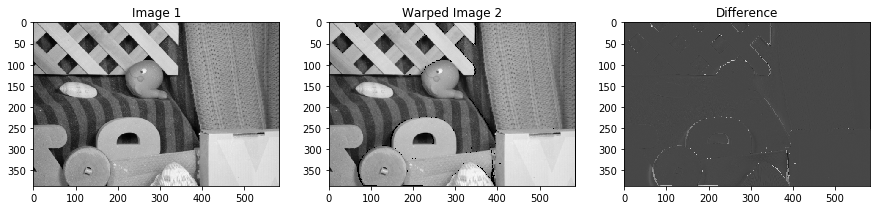


Coarse to fine ...
Level 5


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


LBFGS AEPE:  tensor(6665966.)
LBFGS AEPE:  tensor(1.2232)
Level 4
LBFGS AEPE:  tensor(14438055.)
LBFGS AEPE:  tensor(1.1673)
Level 3
LBFGS AEPE:  tensor(4842855.)
LBFGS AEPE:  tensor(1.0760)
Level 2
LBFGS AEPE:  tensor(22010786.)
LBFGS AEPE:  tensor(0.8498)
Level 1
LBFGS AEPE:  tensor(0.4577)
LBFGS AEPE:  tensor(0.4577)


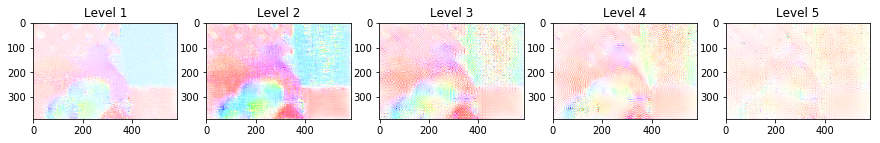

In [92]:
problem2()

In [ ]:
#Der große AEPE kommt daher, dass die gt flow für invalid values >1e9 hat.
#Beim up/downsamplen werden die mit ihren nachbarn interpoliert und dadurch kleiner. 
#Dann sind die immernoch riesig, werden aber nicht mehr gefiltert. 
#Ich hab jetzt einfach die AEPE evaluation mit dem upscaled flo gemacht und mit der ungescaleten gt verglichen. da sind die zahlen zumindest vernünftiger

#man kann anstatt einen faktor auch einfach direkt die gewünschte size als tupel angeben, die ist in jeder iteration floor(originalgröße/ iteration)
# gehen jetzt daher auch von num_iter -> 1 durch 